In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.combine import SMOTETomek
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Step 1: Load and preprocess data
# Load the preprocessed dataset from the specified path
preprocessed_data_path = './4Jan_preprocessed_data.csv'
data = pd.read_csv(preprocessed_data_path, low_memory=False)

# Select relevant features from the dataset
selected_features = ['va_re_logMar', 'va_le_logMar', 'RE_1', 'LE_1', 'age_years', 'TIME_1', 'sex', 'diagnosis1']
data = data[selected_features]

# Handle missing values in numeric columns by replacing them with the column mean
for column in ['va_re_logMar', 'va_le_logMar', 'RE_1', 'LE_1', 'age_years']:
    data[column] = data[column].fillna(data[column].mean())

# Function to validate the format of time strings (e.g., mm:ss.s)
def validate_time_format(time_str):
    try:
        parts = time_str.split(':')
        if len(parts) == 2 and parts[0].isdigit() and float(parts[1]) >= 0:
            return True
        return False
    except:
        return False

# Ensure `TIME_1` column has valid time formats; default invalid entries to '00:00.0'
data['TIME_1'] = data['TIME_1'].apply(lambda x: x if validate_time_format(x) else '00:00.0')

# Function to convert time strings in mm:ss.s format to seconds
def convert_time_to_seconds(time_str):
    try:
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60 + seconds
    except:
        return 0.0

# Convert `TIME_1` column to seconds
data['TIME_1'] = data['TIME_1'].apply(convert_time_to_seconds)

# Fill missing values in the `sex` column with 'Unknown' and drop rows with missing labels
data['sex'] = data['sex'].fillna('Unknown')
data = data.dropna(subset=['diagnosis1'])

# Encode categorical columns (`sex` and `diagnosis1`) into numeric format
label_encoder_sex = LabelEncoder()
data['sex'] = label_encoder_sex.fit_transform(data['sex'])

label_encoder_diagnosis = LabelEncoder()
data['diagnosis1'] = label_encoder_diagnosis.fit_transform(data['diagnosis1'])

# Normalize numeric features to a range of 0 to 1 using MinMaxScaler
scaler = MinMaxScaler()
numeric_columns = ['va_re_logMar', 'va_le_logMar', 'RE_1', 'LE_1', 'age_years', 'TIME_1']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Split features (X) and labels (y)
X = data.drop(columns=['diagnosis1']).values  # Extract independent variables
y = data['diagnosis1'].values  # Extract dependent variable (target labels)

# Reshape features for LSTM input (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])

In [19]:
# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # Stratify split to maintain class distribution

# Flatten training data to 2D for SMOTE-Tomek application
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE-Tomek to handle class imbalance in the training data
smote_tomek = SMOTETomek(random_state=42)  # SMOTE-Tomek to address class imbalance and remove noise
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train_flat, y_train)  # Generate synthetic samples and clean overlaps

# Validate the distribution of the resampled classes to ensure balancing
from collections import Counter
print("Class distribution after resampling:", Counter(y_train_resampled))

# Reshape the resampled data back to 3D for LSTM input
X_train_resampled = X_train_resampled.reshape(-1, 1, X_train_resampled.shape[1])

# One-hot encode target labels for multi-class classification
y_train_categorical = to_categorical(y_train_resampled, num_classes=len(np.unique(y)))
y_test_categorical = to_categorical(y_test, num_classes=len(np.unique(y)))

Class distribution after resampling: Counter({33: 21624, 29: 21624, 31: 21624, 45: 21624, 15: 21624, 28: 21624, 24: 21624, 40: 21624, 14: 21624, 25: 21624, 17: 21624, 3: 21624, 43: 21624, 22: 21624, 49: 21624, 42: 21624, 27: 21624, 39: 21624, 2: 21624, 18: 21624, 51: 21624, 9: 21624, 26: 21624, 48: 21624, 8: 21624, 23: 21624, 32: 21624, 1: 21624, 38: 21624, 13: 21624, 20: 21624, 44: 21624, 19: 21624, 16: 21624, 7: 21624, 41: 21624, 47: 21624, 10: 21624, 4: 21624, 46: 21624, 11: 21624, 34: 21624, 50: 21624, 12: 21624, 30: 21624, 35: 21624, 36: 21624, 0: 21624, 5: 21624, 21: 21624, 37: 21624, 6: 21624})


In [20]:
# Step 2: Model development
# Define the architecture of the LSTM model
model = Sequential([
    BatchNormalization(),  # Batch normalization to stabilize and improve convergence after input
    LSTM(128, return_sequences=True, input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2]), kernel_regularizer='l2'),
    BatchNormalization(),  # Batch normalization after the first LSTM layer,  # First LSTM layer with regularization
    Dropout(0.3),  # Dropout layer to reduce overfitting
    LSTM(64, kernel_regularizer='l2'),
    BatchNormalization(),  # Batch normalization after the second LSTM layer,  # Second LSTM layer
    Dropout(0.3),  # Additional dropout layer
    Dense(len(np.unique(y)), activation='softmax')  # Fully connected output layer with softmax activation
])

# Compile the model using Adam optimizer with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy', TopKCategoricalAccuracy(k=3)])  # Evaluation metrics include top-1 and top-3 accuracy

# Configure early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model on the training data
history = model.fit(X_train_resampled, y_train_categorical,
                    validation_split=0.2,  # Use validation data to monitor generalization and avoid overfitting
                    epochs=50,  # Maximum number of epochs
                    batch_size=64,  # Increase batch size to speed up training for larger datasets,  # Mini-batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)  # Print training progress

d:\Programing\Tool\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
14056/14056 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.6136 - loss: 2.2317 - top_k_categorical_accuracy: 0.7563 - val_accuracy: 0.1337 - val_loss: 3.6982 - val_top_k_categorical_accuracy: 0.3263
Epoch 2/50
14056/14056 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.8314 - loss: 0.7382 - top_k_categorical_accuracy: 0.9401 - val_accuracy: 0.3263 - val_loss: 2.4275 - val_top_k_categorical_accuracy: 0.4831
Epoch 3/50
14056/14056 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.8602 - loss: 0.5863 - top_k_categorical_accuracy: 0.9573 - val_accuracy: 0.4723 - val_loss: 1.7318 - val_top_k_categorical_accuracy: 0.6381
Epoch 4/50
14056/14056 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.8734 - loss: 0.5193 - top_k_categorical_accuracy: 0.9649 - val_accuracy: 0.5003 - val_loss: 1.4626 - val_top_k_categorical_accuracy: 0.6824
Epoch 5/50
14056/14056 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.8838 - loss: 0.4748 - top_k_categorical_accuracy: 0.9699 - val_accuracy: 0.5479 - val

536/536 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Filtered Indices: [40, 29]
Filtered y_test (sample): [29, 29, 29, 40, 29, 29, 29, 29, 40, 29]
Filtered y_pred (sample): [18, 29, 29, 40, 18, 7, 41, 29, 18, 29]
Filtered Classification Report:
                      precision    recall  f1-score   support

Retinitis pigmentosa       0.93      0.84      0.88      2397
              Normal       0.97      0.65      0.78      5406

           micro avg       0.96      0.71      0.81      7803
           macro avg       0.95      0.74      0.83      7803
        weighted avg       0.96      0.71      0.81      7803



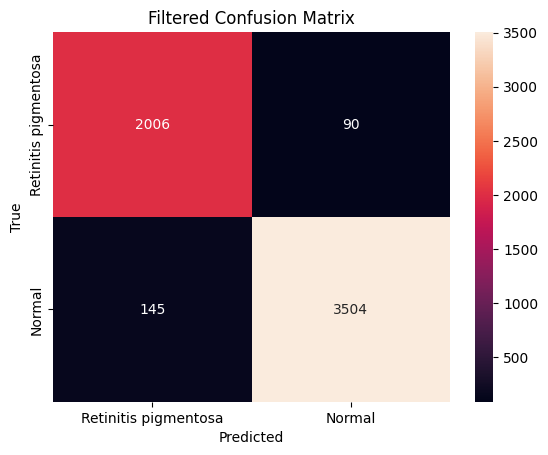

First Choice Accuracy for class 'Retinitis pigmentosa': 95.7061%
First Choice Accuracy for class 'Normal': 96.0263%
Top-3 Accuracy for class 'Retinitis pigmentosa': 99.8748%
Top-3 Accuracy for class 'Normal': 98.4092%
Test Loss: 0.5548
Test Accuracy: 83.4150%
Test Top-3 Accuracy: 99.2880%
Final model saved to final_lstm_model_20250109_191746.keras


In [21]:
# Step 3: Model Evaluation
# Generate predictions on the test data
y_pred = model.predict(X_test)  # Obtain predicted probabilities
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Generate a classification report and confusion matrix for specific classes
filtered_classes = ['Retinitis pigmentosa', 'Normal']  # Removed 'Cone-Rod dystrophy'
filtered_indices = [list(label_encoder_diagnosis.classes_).index(cls) for cls in filtered_classes]

# Filter y_test and y_pred_labels for selected classes
y_test_filtered = [y for y in y_test if y in filtered_indices]
y_pred_filtered = [y_pred_labels[i] for i in range(len(y_test)) if y_test[i] in filtered_indices]

print("Filtered Indices:", filtered_indices)
print("Filtered y_test (sample):", y_test_filtered[:10])  # Print first 10 values for inspection
print("Filtered y_pred (sample):", y_pred_filtered[:10])  # Print first 10 predictions

filtered_class_names = [label_encoder_diagnosis.classes_[i] for i in filtered_indices]

# Generate a classification report for the filtered classes
filtered_class_report = classification_report(y_test_filtered, y_pred_filtered, labels=filtered_indices, target_names=filtered_class_names, zero_division=0)
print("Filtered Classification Report:")
print(filtered_class_report)

# Compute the confusion matrix for the filtered classes
filtered_conf_matrix = confusion_matrix(y_test_filtered, y_pred_filtered, labels=filtered_indices)
sns.heatmap(filtered_conf_matrix, annot=True, fmt='d', xticklabels=filtered_class_names, yticklabels=filtered_class_names)
plt.title('Filtered Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate first choice accuracy for specific classes
for idx in filtered_indices:
    acc = filtered_conf_matrix[filtered_indices.index(idx), filtered_indices.index(idx)] / filtered_conf_matrix[filtered_indices.index(idx)].sum()
    print(f"First Choice Accuracy for class '{label_encoder_diagnosis.classes_[idx]}': {acc * 100:.4f}%")

# Calculate top-3 accuracy for specific classes
from collections import defaultdict
class_top3_accuracy = defaultdict(list)

for true_label, pred_probs in zip(y_test, y_pred):
    top_3_preds = np.argsort(pred_probs)[-3:][::-1]  # Get the top 3 predicted classes
    class_top3_accuracy[true_label].append(int(true_label in top_3_preds))

for cls in filtered_classes:
    class_id = list(label_encoder_diagnosis.classes_).index(cls)
    correct_preds = class_top3_accuracy[class_id]
    accuracy = sum(correct_preds) / len(correct_preds) * 100 if correct_preds else 0
    print(f"Top-3 Accuracy for class '{cls}': {accuracy:.4f}%")

# Evaluate the model on the test dataset
results = model.evaluate(X_test, y_test_categorical, verbose=0)  # Evaluate loss and accuracy
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1] * 100:.4f}%")
print(f"Test Top-3 Accuracy: {results[2] * 100:.4f}%")

# Save the trained model with a unique timestamp
from datetime import datetime
model_version = datetime.now().strftime('%Y%m%d_%H%M%S')
model.save(f'./final_lstm_model_{model_version}.keras')
print(f"Final model saved to final_lstm_model_{model_version}.keras")


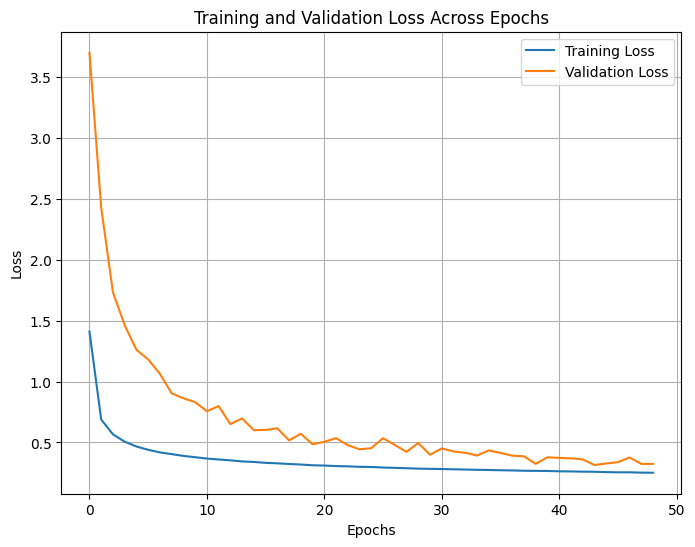

In [22]:
# Plot Training and Validation Loss Across Epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

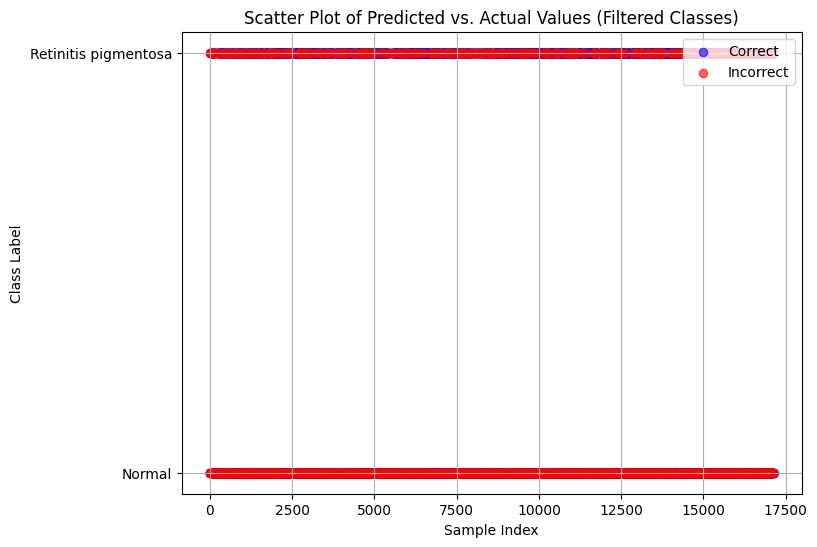

In [23]:
# Optimized Scatter Plot of Predicted vs. Actual Values for Filtered Classes
filtered_indices_set = set(filtered_indices)
plt.figure(figsize=(8, 6))

# Separate correct and incorrect predictions
correct_indices = [
    i for i, (true, pred) in enumerate(zip(y_test, y_pred_labels))
    if true in filtered_indices_set and true == pred
]
incorrect_indices = [
    i for i, (true, pred) in enumerate(zip(y_test, y_pred_labels))
    if true in filtered_indices_set and true != pred
]

# Plot correct predictions
plt.scatter(
    correct_indices, 
    [y_test[i] for i in correct_indices], 
    color='blue', label='Correct', alpha=0.6
)
# Plot incorrect predictions
plt.scatter(
    incorrect_indices, 
    [y_test[i] for i in incorrect_indices], 
    color='red', label='Incorrect', alpha=0.6
)

# Adjust y-axis to match filtered class names
plt.yticks(ticks=filtered_indices, labels=filtered_class_names)

plt.title('Scatter Plot of Predicted vs. Actual Values (Filtered Classes)')
plt.xlabel('Sample Index')
plt.ylabel('Class Label')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()